## Setup

In [1]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors # for player to grid assignment
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Read In csvs
folder = '/kaggle/input/nfl-big-data-bowl-2025/'
games = pd.read_csv(folder + "games.csv")
plays = pd.read_csv(folder + "plays.csv")
players = pd.read_csv(folder + "players.csv")
player_play = pd.read_csv(folder+"player_play.csv")
week1 = pd.read_csv(folder + "tracking_week_1.csv")

In [3]:
full_tracking_data = pd.concat([week1,
                                pd.read_csv(folder + "tracking_week_2.csv"),
                                pd.read_csv(folder + "tracking_week_3.csv"),
                                pd.read_csv(folder + "tracking_week_4.csv"),
                                pd.read_csv(folder + "tracking_week_5.csv"),
                                pd.read_csv(folder + "tracking_week_6.csv"),
                                pd.read_csv(folder + "tracking_week_7.csv"),
                                pd.read_csv(folder + "tracking_week_8.csv"),
                                pd.read_csv(folder + "tracking_week_9.csv")],
                             ignore_index=True)
full_tracking_data.shape

(59327373, 18)

## Determining whether a play was a Run, Pass, or RPO

In [4]:
# Group by gameId and playId and sum the hadRushAttempt column
rush_attempts = player_play.groupby(['gameId', 'playId'])['hadRushAttempt'].sum().reset_index()

# Rename the summed column to rushAttempt
rush_attempts.rename(columns={'hadRushAttempt': 'rushAttempt'}, inplace=True)

# Merge this data back into the original plays DataFrame
plays = plays.merge(rush_attempts, on=['gameId', 'playId'], how='left')

# If you want to fill missing values with 0 (in case some playId groups had no rush attempts)
plays['rushAttempt'] = plays['rushAttempt'].fillna(0).astype(int)

#print(plays['rushAttempt'])


In [5]:
# Define conditions
# it will check these in order, so 
# - if it's an rpo then it's a rpo, 
# - if there is anything in the pass result column it's a pass, (do this before runs to capture scrambles)
# - then if there's a rush attempt it's a run
# - finally, if we miss anything it's just 'unknown' (but we don't miss anything)
conditions = [
    plays['pff_runPassOption'] == 1,                  # Condition for 'rpo'
    plays['passResult'].notna(),                      # Condition for 'pass'
    plays['rushAttempt'] == 1                         # Condition for 'run'
]

# Define corresponding values
choices = ['rpo', 'pass', 'run']

# Use numpy.select to create the column based on conditions
plays['type'] = np.select(conditions, choices, default='unknown')
plays['type'].value_counts()

type
pass    9242
run     5248
rpo     1634
Name: count, dtype: int64

In [6]:
## Look at type of play by formation
plays.groupby('offenseFormation')['type'].value_counts()

offenseFormation  type
EMPTY             pass    1292
                  run       29
                  rpo       21
I_FORM            run      720
                  pass     293
                  rpo       22
JUMBO             run      104
                  pass      21
PISTOL            run      362
                  pass     210
                  rpo       69
SHOTGUN           pass    6131
                  rpo     1361
                  run     1299
SINGLEBACK        run     2499
                  pass    1261
                  rpo      155
WILDCAT           run       70
                  pass      11
                  rpo        6
Name: count, dtype: int64

## Handling the tracking data and getting useful features from it

### First, a function to get the at-snap locations for a given play

In [7]:
def get_play_locations(gameId, playId, plays, tracking_df, snap_frame_offset = 0, rotate=True, ball_relative=True, show_plot=False,need_to_subset=True):
    '''
    Parameters:
        - gameId: int
        - playId: int
        - plays: pd.DataFrame, the data from plays.csv
        - tracking_df: pd.DataFrame, has all the columns in the tracking datasets
        - snap_frame_offset: int, default = 0, the player locations will be taken at the snap_frame + offset
        - rotate: bool, default = True, whether or not to rotate the plays going left to face right
        - ball_relative: bool, default = True, whether or not to adjust the player locations to be relative to the ball
        - show_plot: bool, default = False, whether or not to show the plot of player locations and the ball

    Returns:
        ball, offense_at_snap
        - ball: pd.DataFrame, has one row containing the tracking information of the ball at the first frame of the play
        - offense_at_snap: pd.DataFrame, has a row for each player on the offensive team containing their tracking information at the frame of the snap (plus the offset)
    '''
    if need_to_subset:
        # Filter plays and extract relevant data
        play_data = plays[(plays['gameId'] == gameId) & (plays['playId'] == playId)]
        play = tracking_df[(tracking_df['gameId'] == gameId) & (tracking_df['playId'] == playId)]
    else:
        play_data = plays
        play = tracking_df

    posteam = play_data['possessionTeam'].values[0]
    
    if not play['event'].isin(['ball_snap']).any():
        raise ValueError("Ball Wasn't Snapped")
        
    snap_frame = play.loc[play['event'] == 'ball_snap', 'frameId'].values[0]
    
    # Get the location of players at the snap frame 
    # (may want to adjust where relative to the snap frame we look, since it seems like at the snap frame the ball and players are moving)
    at_snap = play[play['frameId'] == snap_frame + snap_frame_offset]
    offense_at_snap = at_snap[at_snap['club'] == posteam].copy()  # Explicitly make a copy

    # Get the ball's initial location at frame 1 (at the snap frame, it is already moving)
    ball = play.loc[(play['frameId'] == 1) & (play['displayName'] == 'football'), ['x', 'y', 'playDirection']].copy()

    # Rotate the locations if requested and if the play isn't already going right
    if rotate and ball['playDirection'].iloc[0] == 'left':
        max_x, max_y = 120, 53.3
        offense_at_snap['x'] = max_x - offense_at_snap['x']
        offense_at_snap['y'] = max_y - offense_at_snap['y']
        ball['x'] = max_x - ball['x']
        ball['y'] = max_y - ball['y']

    # Convert to ball-relative coordinates if requested
    if ball_relative:
        ball_x, ball_y = ball.iloc[0, :2]
        offense_at_snap[['x', 'y']] -= [ball_x, ball_y]
        ball[['x', 'y']] = [0, 0]

    # Plot if requested
    if show_plot:
        plt.figure(figsize=(10, 6))
        plt.scatter(offense_at_snap['x'], offense_at_snap['y'], c='blue', label='Player Position')
        plt.scatter(ball['x'], ball['y'], c='red', label='Ball Position')
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.title('Player Positions on the Field')
        plt.grid(True)
        plt.legend()
        plt.show()

    return ball, offense_at_snap


### Second, a function to make a binary matrix representing the locations of players

In [8]:
def get_binary_matrix(df, square_length_x=1, square_length_y=1, show_plot=False, plotting_size_constant = 0.15):
    '''
    Params:
        - df: pd.DataFrame, offense_at_snap dataframe from the get_play_locations function with rotate=True and ball_relative=True
        - square_length_x: float, default = 1, the side length (in yards) along the x direction of each grid square
        - square_length_y: float, default = 1, the side length (in yards) along the y direction of each grid square
        - show_plot: bool, default = False, whether or not to show the plot of the grid and player locations
        - plotting_size_constant: float, default = 0.15, constant to scale the size of the plot

    Returns:
        - binary_matrix: np.array, matrix representing the grid, with 1s where the players are and 0s everywhere else
    '''
    # Define the grid range
    x_range = np.arange(-10, 1, square_length_x)  # Horizontal range of the field
    y_range = np.arange(-33, 34, square_length_y)  # Vertical range of the field
    
    # Generate grid centers using np.meshgrid for more efficient generation
    x_centers, y_centers = np.meshgrid(x_range + square_length_x / 2, y_range + square_length_y / 2)
    grid_centers = np.column_stack([x_centers.ravel(), y_centers.ravel()])  # Flatten the arrays

    # Use NearestNeighbors for faster square assignment
    tree = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(grid_centers)
    player_coords = df[['x', 'y']].values
    if np.any(player_coords[:, 0] >= 0):
        # Calculate the shift: how much to subtract to make all x values negative
        shift_amount = np.max(player_coords[:, 0]) + .01 # + 0.01 to make sure everything is strictly negative
        player_coords[:, 0] -= shift_amount
    distances, indices = tree.kneighbors(player_coords)
    
    # Assign square indices directly and the corresponding grid center
    ## Note that if multiple players are in the same square, it doesn't do anything special
    df['square_idx'] = indices.ravel()
    df['assigned_square_x'], df['assigned_square_y'] = grid_centers[indices.ravel()].T

    # Plot if requested
    if show_plot:
        y_size = max(y_range) - min(y_range) + 1
        x_size = max(x_range) - min(x_range) + 1
        plt.figure(figsize=(plotting_size_constant * x_size, plotting_size_constant * y_size))
    
        # Color the grid squares
        for i, (x, y) in enumerate(grid_centers):
            players_in_square = df[df['square_idx'] == i]
            plt.gca().add_patch(plt.Rectangle(
                (x - square_length_x / 2, y - square_length_y / 2),
                square_length_x, square_length_y,
                facecolor='black' if not players_in_square.empty else 'white',
                edgecolor='black', alpha=0.5 if not players_in_square.empty else 1
            ))
    
        # Plot player positions
        for idx, row in df.iterrows():
            # Scale dot size based on the plotting_size_constant (for example, multiplying by 10 for visibility)
            player_size = plotting_size_constant * 100  # adjust the multiplier as needed for size visibility
            plt.scatter(row['x'], row['y'], label=row['displayName'], color='red', s=player_size)
    
        # Add grid lines
        for x in x_range:
            plt.axvline(x, color='gray', linestyle='--')
        for y in y_range:
            plt.axhline(y, color='gray', linestyle='--')
    
        # Add labels and title
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.title('Player Positions and Grid Squares')
    
        plt.ylim(min(y_range), max(y_range))
        plt.xlim(min(x_range), max(x_range))
        plt.grid(True)
        plt.show()


    # Calculate binary matrix dimensions
    num_rows = int(np.ceil((y_range[-1] - y_range[0]) / square_length_y))
    num_cols = int(np.ceil((x_range[-1] - x_range[0]) / square_length_x))
    binary_matrix = np.zeros((num_rows, num_cols), dtype=int)

    # Map grid centers to binary matrix
    for i, (x, y) in enumerate(grid_centers):
        row = int((y_range[-1] - y) // square_length_y)
        col = int((x - x_range[0]) // square_length_x)

        if not df[df['square_idx'] == i].empty:
            binary_matrix[row, col] = 1

    # Return the binary matrix
    return binary_matrix

### Now, look at the results for a couple of plays

In [9]:
## Look at some of the gameIds and playIds we have in week1
week1[['gameId','playId']].drop_duplicates().reset_index(drop=True)

,gameId,playId
0,2022091200,64
1,2022091200,85
2,2022091200,109
3,2022091200,156
4,2022091200,180
...,...,...
1947,2022090800,3576
1948,2022090800,3617
1949,2022090800,3636
1950,2022090800,3674


Raw Locations


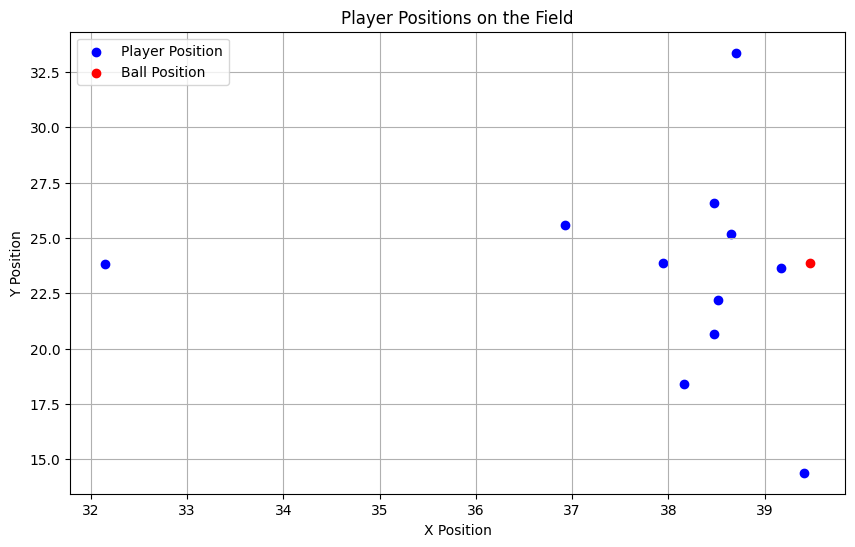

Location Relative to Football:


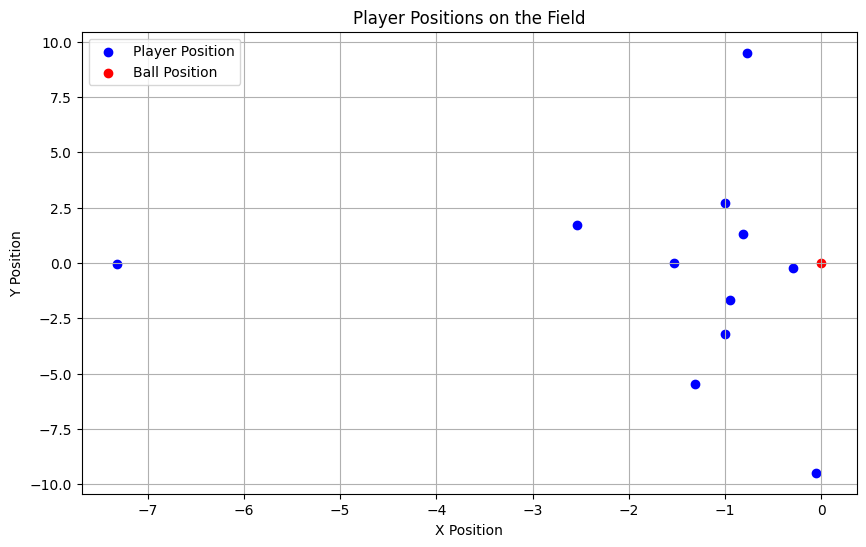

Binary Matrix of Locations:


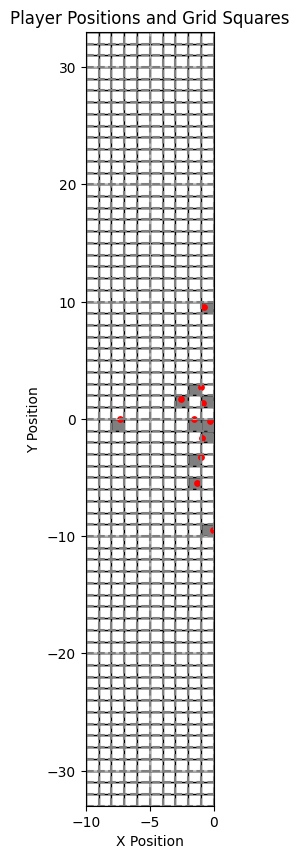

In [10]:
print("Raw Locations")
ball,offense_at_snap = get_play_locations(2022091200,64,plays,week1,ball_relative=False,show_plot=True)
print("Location Relative to Football:")
ball,offense_at_snap = get_play_locations(2022091200,64,plays,week1,show_plot=True)
print("Binary Matrix of Locations:")
mat = get_binary_matrix(offense_at_snap,show_plot=True)

Raw Locations:


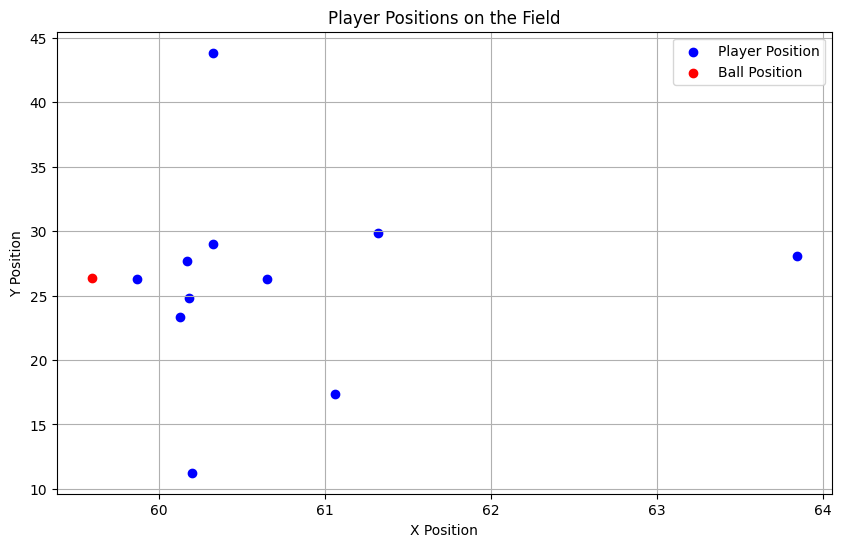

Rotated to Face Right:


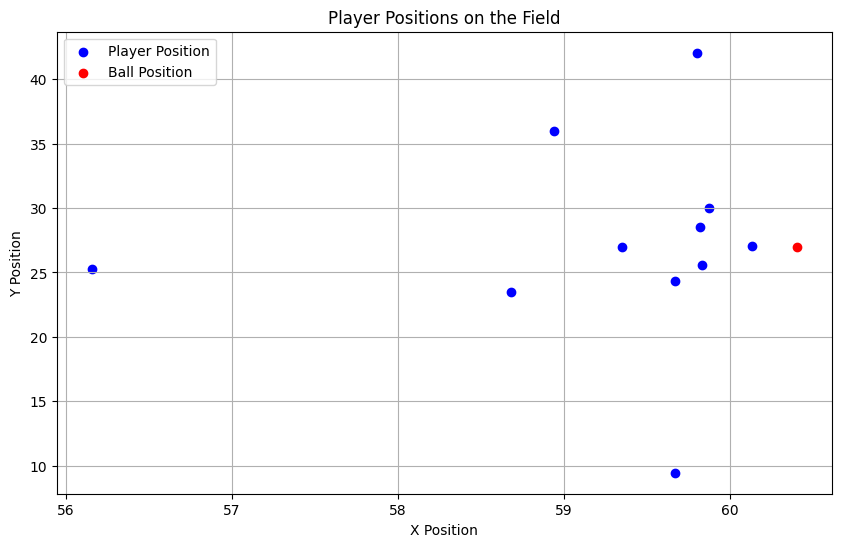

Location Relative to Football:


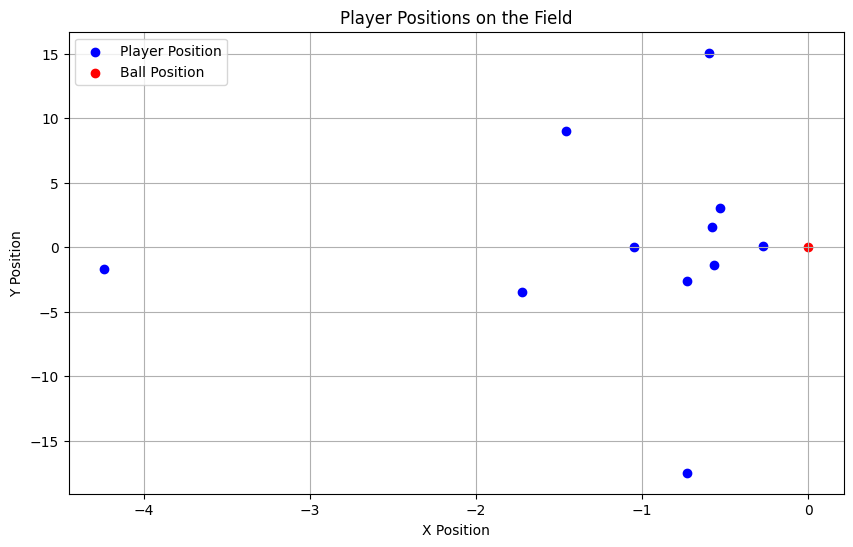

Binary Matrix of Locations:


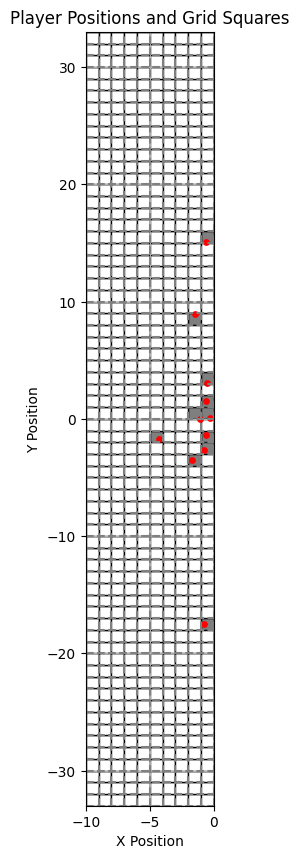

In [11]:
print("Raw Locations:")
ball,offense_at_snap = get_play_locations(2022091101,4128,plays,week1,rotate=False,ball_relative=False,show_plot=True)
print("Rotated to Face Right:")
ball,offense_at_snap = get_play_locations(2022091101,4128,plays,week1,ball_relative=False,show_plot=True)
print("Location Relative to Football:")
ball,offense_at_snap = get_play_locations(2022091101,4128,plays,week1,show_plot=True)
print("Binary Matrix of Locations:")
mat = get_binary_matrix(offense_at_snap,show_plot=True)

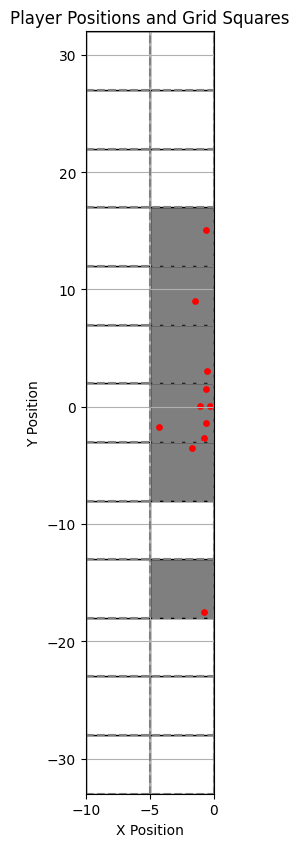

array([[0, 0],
       [0, 0],
       [0, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 0],
       [0, 1],
       [0, 0],
       [0, 0],
       [0, 0]])

In [12]:
## Note that if multiple players are in the same square, it doesn't do anything special
get_binary_matrix(offense_at_snap,show_plot=True,square_length_x=5,square_length_y=5)

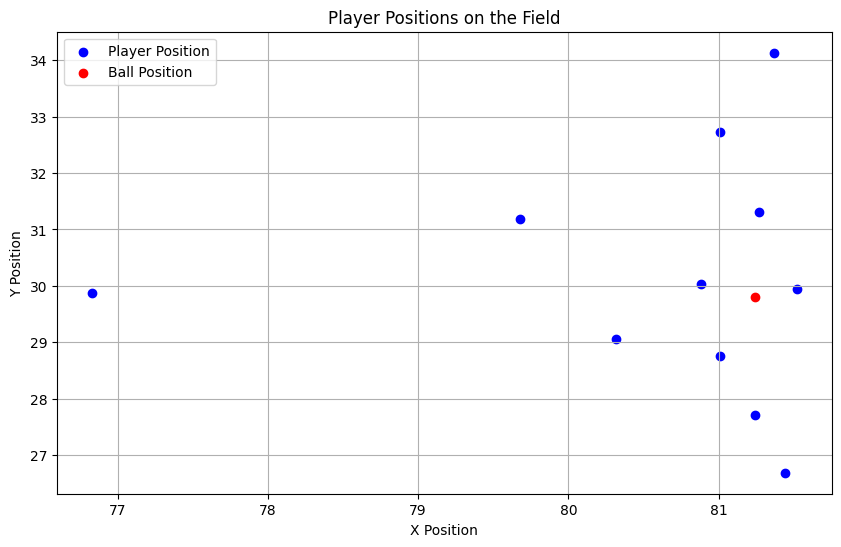

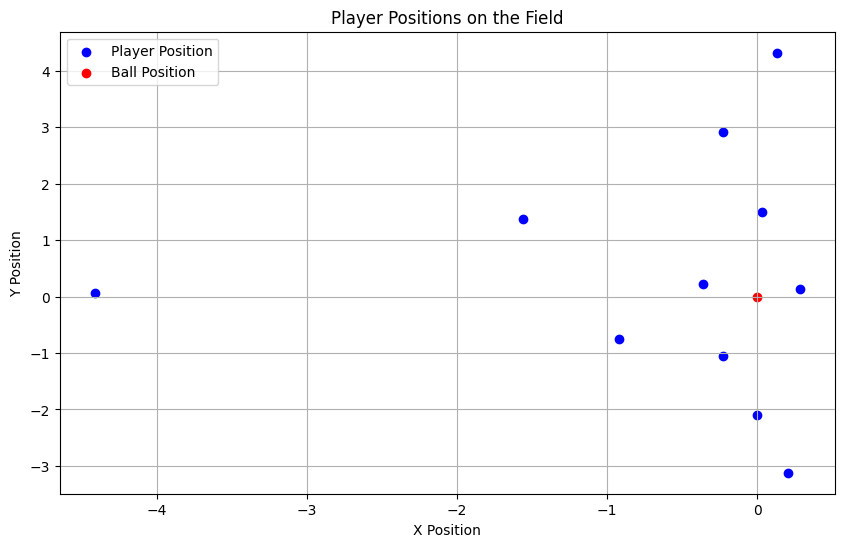

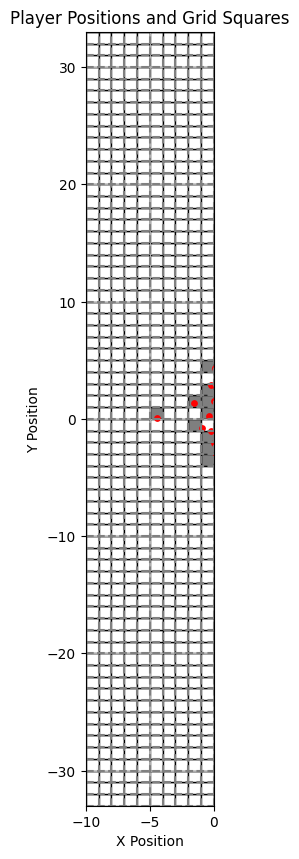

In [13]:
## What is going on with this play?  Is it weird because it's a kneel?
ball,offense_at_snap = get_play_locations(2022100203,3994,plays,full_tracking_data,ball_relative=False,show_plot=True)
# display(ball)
# display(offense_at_snap)
ball,offense_at_snap = get_play_locations(2022100203,3994,plays,full_tracking_data,show_plot=True)
mat = get_binary_matrix(offense_at_snap,show_plot=True)

'(3:18) J.Herron reported in as eligible.  J.Jacobs left guard to DEN 3 for -2 yards (D.Jones).'

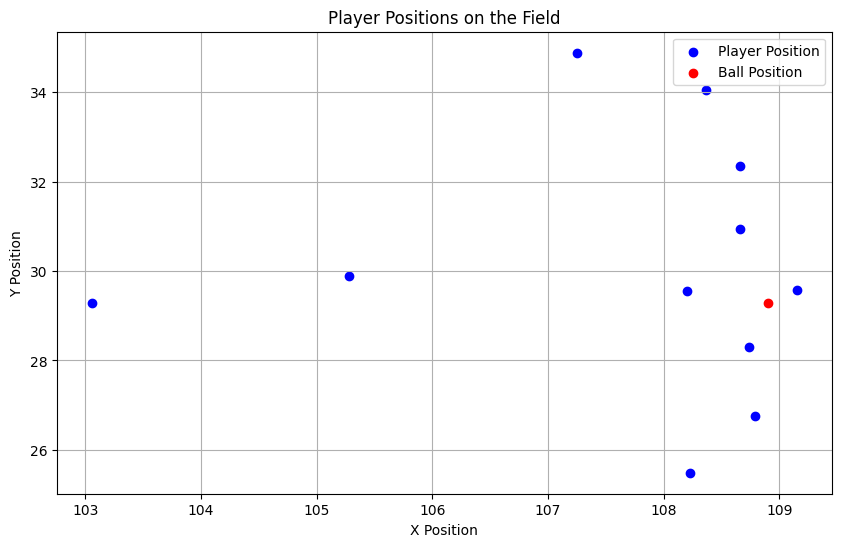

,x,y,playDirection
22125753,108.9,29.28,left


,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
22123215,2022100212,2463,41265.0,Derek Carr,103,SNAP,2022-10-02 22:34:02,4.0,LV,left,108.20,29.55,0.01,0.01,0.03,256.60,38.96,ball_snap
22123611,2022100212,2463,42547.0,Darren Waller,103,SNAP,2022-10-02 22:34:02,83.0,LV,left,107.25,34.88,1.90,1.94,0.18,277.62,194.20,ball_snap
22124139,2022100212,2463,46084.0,Kolton Miller,103,SNAP,2022-10-02 22:34:02,74.0,LV,left,108.66,32.35,0.14,0.70,0.02,285.96,302.66,ball_snap
22124403,2022100212,2463,47749.0,Jakob Johnson,103,SNAP,2022-10-02 22:34:02,45.0,LV,left,105.28,29.88,0.04,0.05,0.10,248.03,193.13,ball_snap
22124535,2022100212,2463,47807.0,Josh Jacobs,103,SNAP,2022-10-02 22:34:02,28.0,LV,left,103.06,29.29,0.00,0.00,0.01,264.00,356.68,ball_snap
22124799,2022100212,2463,48158.0,Alex Bars,103,SNAP,2022-10-02 22:34:02,64.0,LV,left,108.66,30.93,0.35,1.56,0.03,263.14,300.73,ball_snap
22124931,2022100212,2463,48235.0,Andre James,103,SNAP,2022-10-02 22:34:02,68.0,LV,left,109.15,29.58,0.28,1.66,0.03,237.85,1.03,ball_snap
22125063,2022100212,2463,48700.0,Jesper Horsted,103,SNAP,2022-10-02 22:34:02,80.0,LV,left,108.23,25.49,0.00,0.08,0.01,230.92,122.27,ball_snap
22125195,2022100212,2463,52603.0,Justin Herron,103,SNAP,2022-10-02 22:34:02,71.0,LV,left,108.37,34.04,0.02,0.18,0.00,277.88,244.90,ball_snap
22125591,2022100212,2463,54555.0,Dylan Parham,103,SNAP,2022-10-02 22:34:02,66.0,LV,left,108.74,28.30,0.15,0.88,0.02,246.70,9.04,ball_snap


In [14]:
## Apparently I need to handle the case where players are in front of the ball for some reason
display(plays[(plays['gameId']==2022100212) & (plays['playId'] == 2463)]['playDescription'].item())
ball,offense_at_snap = get_play_locations(2022100212,2463,plays,full_tracking_data,ball_relative=False,show_plot=True)
display(ball)
display(offense_at_snap)

In [15]:
#ball,offense_at_snap = get_play_locations(2022103005,121,plays,full_tracking_data,ball_relative=False,show_plot=True)

## Predicting Offensive Formations

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


#### Create Dataset

In [17]:
def get_grids_and_labels(plays, full_tracking_data, square_length_x = 1, square_length_y = 1):
    '''
    This function is an optimized combination of get_play_locations and get_binary_matrix designed to run on the full dataset at once
    '''
    grids = []
    labels = []
    
    # Filter down to only what we need
    temp_tracking = full_tracking_data[((full_tracking_data['displayName'] == 'football') & (full_tracking_data['frameId'] == 1)) | ((full_tracking_data['event'] == 'ball_snap') & (full_tracking_data['displayName']!='football'))]

    # Group the dataframes for faster lookup
    plays_grouped = plays[['gameId','playId','possessionTeam','offenseFormation','qbKneel','qbSpike']].groupby(['gameId','playId'])
    temp_tracking_grouped = temp_tracking.groupby(['gameId','playId'])

    ## Precompute some other stuff
    
    
    x_range = np.arange(-10, 1, square_length_x)  # Horizontal range of the field
    y_range = np.arange(-33, 34, square_length_y)  # Vertical range of the field
    
    # Generate grid centers using np.meshgrid for more efficient generation
    x_centers, y_centers = np.meshgrid(x_range + square_length_x / 2, y_range + square_length_y / 2)
    grid_centers = np.column_stack([x_centers.ravel(), y_centers.ravel()])  # Flatten the arrays
    
    # Use NearestNeighbors for faster square assignment
    tree = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(grid_centers)
    
    # Calculate binary matrix dimensions
    num_rows = int(np.ceil((y_range[-1] - y_range[0]) / square_length_y))
    num_cols = int(np.ceil((x_range[-1] - x_range[0]) / square_length_x))

    # Map grid centers to binary matrix
    mapping = {}
    for i, (x, y) in enumerate(grid_centers):
        row = int((y_range[-1] - y) // square_length_y)
        col = int((x - x_range[0]) // square_length_x)
        mapping[i] = (row,col)


    for key,grouped in tqdm(temp_tracking_grouped):
        if len(grouped) == 1: # this only happens if the ball wasn't snapped
            continue 
            
        play_information = plays_grouped.get_group(key)
        if play_information['qbSpike'].values[0]==1 or play_information['qbKneel'].values[0]==1: # don't deal with spikes and kneels
            continue
        
        posteam = play_information['possessionTeam'].values[0]
        offense = grouped[grouped['club'].isin([posteam,'football'])].copy()
        max_x, max_y = 120, 53.3
        if offense['playDirection'].values[0] == 'left':
            # rotate
            offense['x'] = max_x - offense['x']
            offense['y'] = max_y - offense['y']
    
        
        ball = offense[offense['displayName']=='football']
        offense = offense[offense['displayName']!='football']
        
        offense[['x', 'y']] -= [ball['x'].values[0], ball['y'].values[0]]
        offense = offense[['x', 'y']]
        player_coords = offense.values
    
        if np.any(player_coords[:, 0] >= 0):
            # Calculate the shift: how much to subtract to make all x values negative
            shift_amount = np.max(player_coords[:, 0]) + .01 # + 0.01 to make sure everything is strictly negative
            player_coords[:, 0] -= shift_amount
        
        distances, indices = tree.kneighbors(player_coords)
    
        offense['square_idx'] = indices.ravel()
        offense['assigned_square_x'], offense['assigned_square_y'] = grid_centers[indices.ravel()].T
    
    
        binary_matrix = np.zeros((num_rows, num_cols), dtype=int)
    
        # Map grid centers to binary matrix using precomputed assignments:
        binary_matrix = np.zeros((num_rows, num_cols), dtype=int)
        player_square_indices = offense['square_idx'].values    
        for i in player_square_indices:
            row,col = mapping[i]
            binary_matrix[row, col] = 1

        grids.append(torch.tensor(binary_matrix, dtype=torch.float32))
        labels.append(play_information['offenseFormation'].values[0])

    return grids,labels

In [18]:
class PrecomputedOffenseDataset(Dataset):
    """
    Dataset class for precomputed grids and labels.
    """
    def __init__(self, tensor_grids, tensor_labels,flip=False):
        self.grids = tensor_grids
        self.labels = tensor_labels

        if flip:
            flipped_grids = [torch.flip(grid, dims=[0]) for grid in tensor_grids]  # Flip along height (vertical axis)
            self.grids.extend(flipped_grids)
            self.labels = torch.cat([self.labels, self.labels], dim=0)  # Duplicate labels for flipped grids

    def __len__(self):
        return len(self.grids)

    def __getitem__(self, idx):
        return self.grids[idx], self.labels[idx]



def precompute_data(plays, full_tracking_data, save_path="precomputed_data.pt"):
    """
    Precomputes binary matrices and labels, saves them to a file, and returns them as tensors.
    
    Args:
        plays (pd.DataFrame): The plays dataframe containing play information.
        full_tracking_data (pd.DataFrame): The full tracking data containing player locations.
        save_path (str): Path to save the precomputed data.        
    Returns:
        Tuple: (grids, encoded_labels, le, grid_shape)
    """
    
    grids,labels = get_grids_and_labels(plays,full_tracking_data)

    # Encode labels
    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels)
    encoded_labels = torch.tensor(encoded_labels, dtype=torch.long)  # Convert to tensor

    # Save data
    torch.save((grids, encoded_labels, le, grids[0].shape), save_path)
    print(len(grids))
    return grids, encoded_labels, le, grids[0].shape

def setup_data_from_precomputed(save_path="precomputed_data.pt", test_split=0.3, batch_size=32,train_flip=False,test_flip=False):
    """
    Loads precomputed data and splits it into train, validation, and test sets.
    """
    # Load precomputed data
    grids, labels, le, shape = torch.load(save_path,weights_only=False) # adding the weights_only argument makes it so pytorch doesn't yell at us
    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(grids, labels, test_size=test_split, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


    # Create datasets and loaders
    train_dataset = PrecomputedOffenseDataset(X_train, y_train,train_flip)
    val_dataset = PrecomputedOffenseDataset(X_val, y_val,test_flip)
    test_dataset = PrecomputedOffenseDataset(X_test, y_test,test_flip)
    print(f"Training Dataset Size: {len(train_dataset)} | Validation Dataset Size: {len(val_dataset)} | Testing Dataset Size: {len(test_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, len(le.classes_), le, shape

In [19]:
# Precompute data
precompute_data(plays, full_tracking_data)

# Setup data from precomputed
train_loader, val_loader, test_loader, num_classes, le, shape = setup_data_from_precomputed()


100%|██████████| 16124/16124 [01:17<00:00, 206.84it/s]


15874
Training Dataset Size: 11111 | Validation Dataset Size: 2381 | Testing Dataset Size: 2382


In [20]:
# Training function
def train_model(train_loader, val_loader, num_classes, shape, epochs=100, print_every=10, patience=5, model_path="best_model.pth", plot_losses=False, plot_accuracies=False):
    """
    Trains a CNN model and saves the best-performing model to disk.
    
    Args:
        train_loader (DataLoader): Training data loader
        val_loader (DataLoader): Validation data loader
        num_classes (int): Number of classes for classification
        shape (tuple): Input shape of the grid (e.g., (64, 64))
        epochs (int): Number of epochs to train the model
        print_every (int): Frequency to print loss/accuracy statistics
        patience (int): Number of epochs to wait for improvement before early stopping
        model_path (str): Path to save the best model
        plot_losses (bool): Whether to plot training and validation losses
        plot_accuracies (bool): Whether to plot training and validation accuracies
    
    Returns:
        str: Path to the saved best model
    """
    # Initialize the model, criterion, and optimizer
    model = OffenseFormationCNN(num_classes, shape[0], shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    best_val_loss = float('inf')
    best_epoch = 0
    early_stop_counter = 0

    # Initialize lists to store loss and accuracy for plotting
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        for inputs, labels in train_loader:
            inputs = inputs.unsqueeze(1)  # Add channel dimension (for grayscale images)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():  # No gradients needed for validation
            for inputs, labels in val_loader:
                inputs = inputs.unsqueeze(1)  # Add channel dimension (for grayscale images)
                
                # Forward pass
                outputs = model(inputs)
                
                # Calculate loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
    
        # Calculate training and validation accuracy
        train_accuracy = 100 * train_correct / train_total
        val_accuracy = 100 * val_correct / val_total
        
        # Track losses and accuracies for plotting
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        # Print the statistics every `print_every` epochs
        if (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch + 1}/{epochs} | "
                  f"Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}% | "
                  f"Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%")
        elif epoch == 0:
            print(f"Epoch {epoch}/{epochs} | "
                  f"Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}% | "
                  f"Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch + 1  # Save the epoch (1-based index) of the best model
            torch.save(model.state_dict(), model_path)
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping triggered on epoch {epoch + 1}. Best epoch was {best_epoch}.")
                break

    # Plot the losses if specified
    if plot_losses:
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
        plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
        plt.axvline(x=best_epoch, color='r', linestyle='--', label="Best Model")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plot the accuracies if specified
    if plot_accuracies:
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy")
        plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy")
        plt.axvline(x=best_epoch, color='r', linestyle='--', label="Best Model")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.title("Training and Validation Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()

    return model_path

# Test function
def test_model(test_loader, model_path, num_classes, shape):
    """
    Evaluates the trained model on the test set.
    """
    model = OffenseFormationCNN(num_classes,shape[0],shape[1])
    model.load_state_dict(torch.load(model_path,weights_only=True))
    model.eval()

    test_accuracy = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.unsqueeze(1)  # Add channel dimension
            outputs = model(inputs)
            predictions = outputs.argmax(dim=1)
            test_accuracy += (predictions == labels).sum().item()

    test_accuracy /= len(test_loader.dataset)
    print(f"Test Accuracy: {100*test_accuracy:.2f}")
    return test_accuracy

# CNN Model Definition
class OffenseFormationCNN(nn.Module):
    def __init__(self, num_classes, input_height, input_width):
        super(OffenseFormationCNN, self).__init__()
        
        # Define parameters based on input grid size
        self.input_height = input_height
        self.input_width = input_width
        
        # Define convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # Input: 1 channel, Output: 16 channels
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Compute the output size after convolution and pooling
        self._compute_output_size()

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, 128),  # Flattened size after conv layers
            nn.ReLU(),
            # nn.Dropout(.1),
            # nn.Linear(128, 64),  # hidden layer
            # nn.ReLU(),
            # nn.Dropout(.1),
            nn.Linear(128, num_classes)
        )
    
    def _compute_output_size(self):
        # Create a dummy input to calculate the output size after conv layers
        dummy_input = torch.randn(1, 1, self.input_height, self.input_width)
        
        # Pass through conv layers to get the output size
        with torch.no_grad():
            conv_output = self.conv_layers(dummy_input)
        
        # Get the size of the output after convolution and pooling
        self.flattened_size = conv_output.numel()

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

Training Dataset Size: 11111 | Validation Dataset Size: 2381 | Testing Dataset Size: 2382
Epoch 0/100 | Train Loss: 0.9827, Train Accuracy: 67.12% | Val Loss: 0.4090, Val Accuracy: 86.64%
Epoch 2/100 | Train Loss: 0.2772, Train Accuracy: 91.55% | Val Loss: 0.2176, Val Accuracy: 93.66%
Epoch 4/100 | Train Loss: 0.1735, Train Accuracy: 95.19% | Val Loss: 0.1714, Val Accuracy: 95.17%
Epoch 6/100 | Train Loss: 0.1418, Train Accuracy: 96.09% | Val Loss: 0.1496, Val Accuracy: 95.42%
Epoch 8/100 | Train Loss: 0.1169, Train Accuracy: 96.55% | Val Loss: 0.1328, Val Accuracy: 96.18%
Epoch 10/100 | Train Loss: 0.1107, Train Accuracy: 96.64% | Val Loss: 0.1388, Val Accuracy: 96.22%
Epoch 12/100 | Train Loss: 0.0975, Train Accuracy: 97.03% | Val Loss: 0.1270, Val Accuracy: 96.35%
Epoch 14/100 | Train Loss: 0.0910, Train Accuracy: 97.20% | Val Loss: 0.1263, Val Accuracy: 96.47%
Epoch 16/100 | Train Loss: 0.0840, Train Accuracy: 97.34% | Val Loss: 0.1288, Val Accuracy: 96.35%
Epoch 18/100 | Train Los

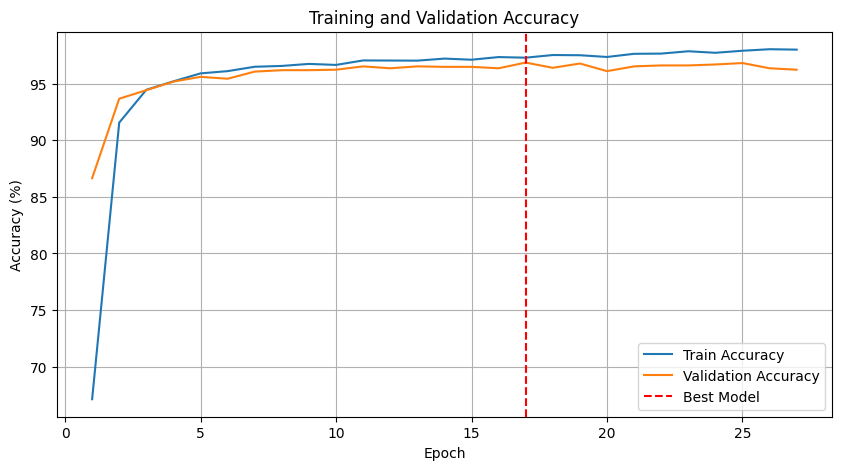

Test Accuracy: 96.60


In [21]:
# Step 1: Setup data
train_loader, val_loader, test_loader, num_classes, le, shape = setup_data_from_precomputed(batch_size = 128)

# Step 2: Train model
model_path = train_model(train_loader, val_loader, num_classes, shape,
                         epochs = 100, print_every = 2, patience = 10, 
                         plot_losses=False, plot_accuracies=True)

# Step 3: Test model
test_accuracy = test_model(test_loader, model_path, num_classes,shape)


Training Dataset Size: 22222 | Validation Dataset Size: 2381 | Testing Dataset Size: 2382
Epoch 0/100 | Train Loss: 0.8123, Train Accuracy: 72.27% | Val Loss: 0.2711, Val Accuracy: 91.89%
Epoch 2/100 | Train Loss: 0.2205, Train Accuracy: 93.85% | Val Loss: 0.1937, Val Accuracy: 95.13%
Epoch 4/100 | Train Loss: 0.1447, Train Accuracy: 96.11% | Val Loss: 0.1409, Val Accuracy: 96.01%
Epoch 6/100 | Train Loss: 0.1206, Train Accuracy: 96.46% | Val Loss: 0.1307, Val Accuracy: 96.30%
Epoch 8/100 | Train Loss: 0.1079, Train Accuracy: 96.71% | Val Loss: 0.1203, Val Accuracy: 96.68%
Epoch 10/100 | Train Loss: 0.0964, Train Accuracy: 97.04% | Val Loss: 0.1180, Val Accuracy: 96.56%
Epoch 12/100 | Train Loss: 0.0919, Train Accuracy: 97.26% | Val Loss: 0.1196, Val Accuracy: 96.14%
Epoch 14/100 | Train Loss: 0.0850, Train Accuracy: 97.37% | Val Loss: 0.1109, Val Accuracy: 96.47%
Epoch 16/100 | Train Loss: 0.0803, Train Accuracy: 97.50% | Val Loss: 0.1124, Val Accuracy: 96.60%
Epoch 18/100 | Train Los

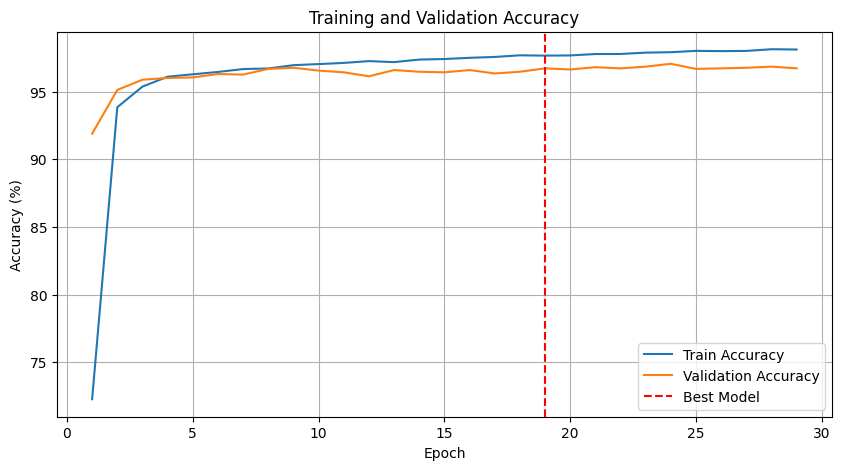

Test Accuracy: 96.81


In [22]:
# Step 1: Setup data
train_loader, val_loader, test_loader, num_classes, le, shape = setup_data_from_precomputed(batch_size = 128,train_flip=True)

# Step 2: Train model
model_path = train_model(train_loader, val_loader, num_classes, shape,
                         epochs = 100, print_every = 2, patience = 10, 
                         plot_losses=False, plot_accuracies=True)

# Step 3: Test model
test_accuracy = test_model(test_loader, model_path, num_classes,shape)

## Predicting Type of play (run, pass, or rpo)

In [23]:
def get_grids_and_labels_type(games, plays, full_tracking_data, square_length_x = 1, square_length_y = 1):
    '''
    This function is an optimized combination of get_play_locations and get_binary_matrix designed to run on the full dataset at once
    '''
    grids = []
    other_x = []
    labels = []
    ids = []
    
    # Filter down to only what we need
    temp_tracking = full_tracking_data[((full_tracking_data['displayName'] == 'football') & (full_tracking_data['frameId'] == 1)) | ((full_tracking_data['event'] == 'ball_snap') & (full_tracking_data['displayName']!='football'))]

    # Group the dataframes for faster lookup
    games_grouped = games.groupby('gameId')
    plays_grouped = plays.groupby(['gameId','playId'])
    temp_tracking_grouped = temp_tracking.groupby(['gameId','playId'])

    ## Precompute some other stuff
    
    
    x_range = np.arange(-10, 1, square_length_x)  # Horizontal range of the field
    y_range = np.arange(-33, 34, square_length_y)  # Vertical range of the field
    
    # Generate grid centers using np.meshgrid for more efficient generation
    x_centers, y_centers = np.meshgrid(x_range + square_length_x / 2, y_range + square_length_y / 2)
    grid_centers = np.column_stack([x_centers.ravel(), y_centers.ravel()])  # Flatten the arrays
    
    # Use NearestNeighbors for faster square assignment
    tree = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(grid_centers)
    
    # Calculate binary matrix dimensions
    num_rows = int(np.ceil((y_range[-1] - y_range[0]) / square_length_y))
    num_cols = int(np.ceil((x_range[-1] - x_range[0]) / square_length_x))

    # Map grid centers to binary matrix
    mapping = {}
    for i, (x, y) in enumerate(grid_centers):
        row = int((y_range[-1] - y) // square_length_y)
        col = int((x - x_range[0]) // square_length_x)
        mapping[i] = (row,col)


    for key,grouped in tqdm(temp_tracking_grouped):
        if len(grouped) == 1: # this only happens if the ball wasn't snapped
            continue 
            
        play_information = plays_grouped.get_group(key)
        if play_information['qbSpike'].values[0]==1 or play_information['qbKneel'].values[0]==1: # don't deal with spikes and kneels
            continue
        
        posteam = play_information['possessionTeam'].values[0]
        offense = grouped[grouped['club'].isin([posteam,'football'])].copy()
        max_x, max_y = 120, 53.3
        if offense['playDirection'].values[0] == 'left':
            # rotate
            offense['x'] = max_x - offense['x']
            offense['y'] = max_y - offense['y']
    
        
        ball = offense[offense['displayName']=='football']
        offense = offense[offense['displayName']!='football']
        
        offense[['x', 'y']] -= [ball['x'].values[0], ball['y'].values[0]]
        offense = offense[['x', 'y']]
        player_coords = offense.values
    
        if np.any(player_coords[:, 0] >= 0):
            # Calculate the shift: how much to subtract to make all x values negative
            shift_amount = np.max(player_coords[:, 0]) + .01 # + 0.01 to make sure everything is strictly negative
            player_coords[:, 0] -= shift_amount
        
        distances, indices = tree.kneighbors(player_coords)
    
        offense['square_idx'] = indices.ravel()
        offense['assigned_square_x'], offense['assigned_square_y'] = grid_centers[indices.ravel()].T
    
    
        binary_matrix = np.zeros((num_rows, num_cols), dtype=int)
    
        # Map grid centers to binary matrix using precomputed assignments:
        binary_matrix = np.zeros((num_rows, num_cols), dtype=int)
        player_square_indices = offense['square_idx'].values    
        for i in player_square_indices:
            row,col = mapping[i]
            binary_matrix[row, col] = 1


        ## The other information we will provide the model to predict the type of play
        
        # Score Differential
        hometeam = games_grouped.get_group(key[0])['homeTeamAbbr'].values[0]
        posteam_is_hometeam = posteam == hometeam
        # score differential is the posteam's score - defteam's score
        #print(play_information['preSnapHomeScore'].values[0], play_information['preSnapVisitorScore'].values[0])
        score_differential = (play_information['preSnapHomeScore'].values[0] - play_information['preSnapVisitorScore'].values[0] 
                              if posteam_is_hometeam else
                              play_information['preSnapVisitorScore'].values[0] - play_information['preSnapHomeScore'].values[0]) 
        
        # Yardline
        yardline = play_information['absoluteYardlineNumber'].values[0] # Distance from end zone for possession team

        # Yards to go
        ydstogo = play_information['yardsToGo'].values[0]

        # Down
        down = play_information['down'].values[0]

        # Quarter
        quarter = play_information['quarter'].values[0]

        # Seconds on Game Clock
        clock = play_information['gameClock'].values[0]
        split = clock.split(':')
        secs_left = int(split[0]) * 60 + int(split[1])

        other_information = torch.tensor(np.array([score_differential,yardline,ydstogo,down,quarter,secs_left]),dtype=torch.float32)

        other_x.append(other_information)
        grids.append(torch.tensor(binary_matrix, dtype=torch.float32))
        labels.append(play_information['type'].values[0])
        ids.append([play_information['gameId'].values[0],play_information['playId'].values[0]])

    return grids,labels,other_x, ids

In [24]:
def precompute_data_type(games,plays, full_tracking_data, save_path="precomputed_data_type.pt"):
    """
    Precomputes binary matrices and labels, saves them to a file, and returns them as tensors.
    
    Args:
        plays (pd.DataFrame): The plays dataframe containing play information.
        full_tracking_data (pd.DataFrame): The full tracking data containing player locations.
        save_path (str): Path to save the precomputed data.        
    Returns:
        Tuple: (grids, encoded_labels, le, grid_shape)
    """
    
    grids,labels,other_x, ids = get_grids_and_labels_type(games,plays,full_tracking_data)

    # Encode labels
    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels)
    encoded_labels = torch.tensor(encoded_labels, dtype=torch.long)  # Convert to tensor

    # Save data
    torch.save((grids, encoded_labels,other_x, le, grids[0].shape, ids), save_path)
    return grids, encoded_labels,other_x, le, grids[0].shape, ids

In [25]:
def setup_data_from_precomputed_type(save_path="precomputed_data_type.pt", test_split=0.3, batch_size=32,train_flip=False,test_flip=False):
    """
    Loads precomputed data and splits it into train, validation, and test sets.
    """
    # Load precomputed data
    grids, labels, other_x, le, shape, ids = torch.load(save_path, weights_only=False)  # Ensure correct unpacking
    
    # Split data
    X_train, X_temp, y_train, y_temp, other_x_train, other_x_temp, id_train, id_temp = train_test_split(
        grids, labels, other_x, ids, test_size=test_split, random_state=42
    )
    X_val, X_test, y_val, y_test, other_x_val, other_x_test, id_val, id_test = train_test_split(
        X_temp, y_temp, other_x_temp, id_temp, test_size=0.5, random_state=42
    )

    # Create datasets and loaders
    train_dataset = PrecomputedOffenseDataset_type(X_train, y_train, other_x_train, id_train,train_flip)
    val_dataset = PrecomputedOffenseDataset_type(X_val, y_val, other_x_val, id_val,test_flip)
    test_dataset = PrecomputedOffenseDataset_type(X_test, y_test, other_x_test, id_test,test_flip)

    print(f"Training Dataset Size: {len(train_dataset)} | Validation Dataset Size: {len(val_dataset)} | Testing Dataset Size: {len(test_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, len(le.classes_), le, shape


class PrecomputedOffenseDataset_type(Dataset):
    """
    Dataset class for precomputed grids, labels, and other_x.
    """
    def __init__(self, tensor_grids, tensor_labels, tensor_other_x, ids,flip=False):
        self.grids = tensor_grids
        self.labels = tensor_labels
        self.other_x = tensor_other_x
        self.ids = ids

        if flip:
            flipped_grids = [torch.flip(grid, dims=[0]) for grid in tensor_grids]  # Flip along height (vertical axis)
            self.grids.extend(flipped_grids)
            self.labels = torch.cat([self.labels, self.labels], dim=0)  # Duplicate labels for flipped grids
            self.other_x.extend(self.other_x)
            self.ids.extend(self.ids)


    def __len__(self):
        return len(self.grids)

    def __getitem__(self, idx):
        return self.grids[idx], self.labels[idx], self.other_x[idx], self.ids[idx]


In [26]:
grids,labels,other_x, le, shape, ids = precompute_data_type(games,plays,full_tracking_data)

train_loader, val_loader, test_loader, num_classes, le, shape = setup_data_from_precomputed_type(batch_size=32)

100%|██████████| 16124/16124 [01:29<00:00, 180.85it/s]


Training Dataset Size: 11111 | Validation Dataset Size: 2381 | Testing Dataset Size: 2382


In [27]:
# Training function
def train_model_type(train_loader, val_loader, num_classes, shape, epochs=100, print_every=10, patience=5, model_path="best_model_type.pth", plot_losses=False, plot_accuracies=False):
    """
    Trains a CNN model and saves the best-performing model to disk.
    
    Args:
        train_loader (DataLoader): Training data loader
        val_loader (DataLoader): Validation data loader
        num_classes (int): Number of classes for classification
        shape (tuple): Input shape of the grid (e.g., (64, 64))
        epochs (int): Number of epochs to train the model
        print_every (int): Frequency to print loss/accuracy statistics
        patience (int): Number of epochs to wait for improvement before early stopping
        model_path (str): Path to save the best model
        plot_losses (bool): Whether to plot training and validation losses
        plot_accuracies (bool): Whether to plot training and validation accuracies
    
    Returns:
        str: Path to the saved best model
    """
    # Initialize the model, criterion, and optimizer
    model = OffenseFormationCNN_type(num_classes, shape[0], shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    best_val_loss = float('inf')
    best_epoch = 0
    early_stop_counter = 0

    # Initialize lists to store loss and accuracy for plotting
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        for grid, labels, other_x, ids in train_loader:
            grid = grid.unsqueeze(1)  # Add channel dimension (for grayscale images)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(grid, other_x)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():  # No gradients needed for validation
            for inputs, labels, other_x, ids in val_loader:
                inputs = inputs.unsqueeze(1)  # Add channel dimension (for grayscale images)
                
                # Forward pass
                outputs = model(inputs,other_x)
                
                # Calculate loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
    
        # Calculate training and validation accuracy
        train_accuracy = 100 * train_correct / train_total
        val_accuracy = 100 * val_correct / val_total
        
        # Track losses and accuracies for plotting
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        # Print the statistics every `print_every` epochs
        if (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch + 1}/{epochs} | "
                  f"Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}% | "
                  f"Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%")
        elif epoch == 0:
            print(f"Epoch {epoch}/{epochs} | "
                  f"Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}% | "
                  f"Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch + 1  # Save the epoch (1-based index) of the best model
            torch.save(model.state_dict(), model_path)
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping triggered on epoch {epoch + 1}. Best epoch was {best_epoch}.")
                break

    # Plot the losses if specified
    if plot_losses:
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
        plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
        plt.axvline(x=best_epoch, color='r', linestyle='--', label="Best Model")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plot the accuracies if specified
    if plot_accuracies:
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy")
        plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy")
        plt.axvline(x=best_epoch, color='r', linestyle='--', label="Best Model")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.title("Training and Validation Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()

    return model_path

# Test function
def test_model_type(test_loader, model_path, num_classes, shape):
    """
    Evaluates the trained model on the test set.
    """
    model = OffenseFormationCNN_type(num_classes,shape[0],shape[1])
    model.load_state_dict(torch.load(model_path,weights_only=True))
    model.eval()

    test_accuracy = 0
    with torch.no_grad():
        for inputs, labels, other_x, ids in test_loader:
            inputs = inputs.unsqueeze(1)  # Add channel dimension
            outputs = model(inputs,other_x)
            predictions = outputs.argmax(dim=1)
            test_accuracy += (predictions == labels).sum().item()

    test_accuracy /= len(test_loader.dataset)
    print(f"Test Accuracy: {100*test_accuracy:.2f}")
    return test_accuracy

# CNN Model Definition
class OffenseFormationCNN_type(nn.Module):
    def __init__(self, num_classes, input_height, input_width, other_x_size=6):
        """
        CNN model that processes grid data with convolutional layers and 
        incorporates other_x as input to the fully connected layers.

        Args:
            num_classes (int): Number of output classes.
            input_height (int): Height of the input grid.
            input_width (int): Width of the input grid.
            other_x_size (int): Size of the additional tensor other_x.
        """
        super(OffenseFormationCNN_type, self).__init__()
        
        # Define parameters based on input grid size
        self.input_height = input_height
        self.input_width = input_width
        self.other_x_size = other_x_size
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # Input: 1 channel, Output: 16 channels
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Compute the output size after convolution and pooling
        self._compute_output_size()

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.flattened_size + self.other_x_size, 128),  # Incorporate other_x in FC layer
            nn.ReLU(),
            nn.Dropout(.1),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Dropout(.1),
            nn.Linear(128, num_classes)
        )
    
    def _compute_output_size(self):
        # Create a dummy input to calculate the output size after conv layers
        dummy_input = torch.randn(1, 1, self.input_height, self.input_width)
        
        # Pass through conv layers to get the output size
        with torch.no_grad():
            conv_output = self.conv_layers(dummy_input)
        
        # Get the size of the output after convolution and pooling
        self.flattened_size = conv_output.numel()

    def forward(self, grid, other_x):
        """
        Forward pass for the CNN model.

        Args:
            grid (torch.Tensor): Input grid tensor of shape (batch_size, 1, height, width).
            other_x (torch.Tensor): Input other_x tensor of shape (batch_size, other_x_size).

        Returns:
            torch.Tensor: Model output logits.
        """
        # Process grid through convolutional layers
        grid_features = self.conv_layers(grid)
        grid_features = grid_features.view(grid_features.size(0), -1)  # Flatten
        
        # Concatenate with other_x
        combined_features = torch.cat((grid_features, other_x), dim=1)
        
        # Pass through fully connected layers
        output = self.fc_layers(combined_features)
        return output


Training Dataset Size: 22222 | Validation Dataset Size: 2381 | Testing Dataset Size: 2382
Epoch 0/100 | Train Loss: 0.9608, Train Accuracy: 56.88% | Val Loss: 0.7609, Val Accuracy: 66.19%
Epoch 2/100 | Train Loss: 0.7460, Train Accuracy: 68.99% | Val Loss: 0.6683, Val Accuracy: 72.24%
Epoch 4/100 | Train Loss: 0.6741, Train Accuracy: 71.25% | Val Loss: 0.6427, Val Accuracy: 72.78%
Epoch 6/100 | Train Loss: 0.6646, Train Accuracy: 71.50% | Val Loss: 0.6285, Val Accuracy: 73.79%
Epoch 8/100 | Train Loss: 0.6508, Train Accuracy: 72.23% | Val Loss: 0.6223, Val Accuracy: 73.46%
Epoch 10/100 | Train Loss: 0.6399, Train Accuracy: 72.53% | Val Loss: 0.6173, Val Accuracy: 73.12%
Epoch 12/100 | Train Loss: 0.6315, Train Accuracy: 73.03% | Val Loss: 0.6135, Val Accuracy: 74.55%
Epoch 14/100 | Train Loss: 0.6250, Train Accuracy: 73.15% | Val Loss: 0.5992, Val Accuracy: 74.17%
Epoch 16/100 | Train Loss: 0.6177, Train Accuracy: 73.58% | Val Loss: 0.6004, Val Accuracy: 74.46%
Epoch 18/100 | Train Los

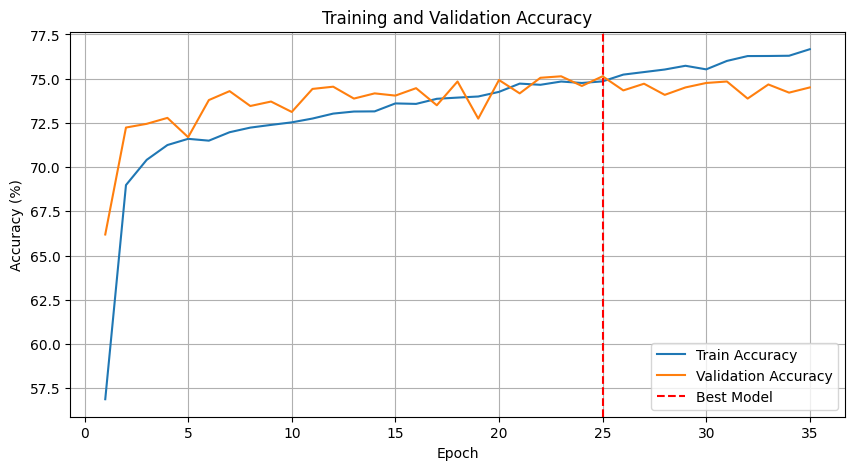

Test Accuracy: 73.51


In [28]:
# Step 1: Setup data
train_loader, val_loader, test_loader, num_classes, le, shape = setup_data_from_precomputed_type(batch_size = 256,train_flip=True)

# Step 2: Train model
model_path = train_model_type(train_loader, val_loader, num_classes, shape,
                         epochs = 100, print_every = 2, patience = 10, 
                         plot_losses=False, plot_accuracies=True)

# Step 3: Test model
test_accuracy = test_model_type(test_loader, model_path, num_classes,shape)

Training Dataset Size: 11111 | Validation Dataset Size: 2381 | Testing Dataset Size: 2382
Epoch 0/100 | Train Loss: 1.0462, Train Accuracy: 53.44% | Val Loss: 0.8822, Val Accuracy: 58.17%
Epoch 2/100 | Train Loss: 0.8485, Train Accuracy: 62.35% | Val Loss: 0.7020, Val Accuracy: 71.52%
Epoch 4/100 | Train Loss: 0.6951, Train Accuracy: 70.99% | Val Loss: 0.6451, Val Accuracy: 72.87%
Epoch 6/100 | Train Loss: 0.6756, Train Accuracy: 71.00% | Val Loss: 0.6485, Val Accuracy: 72.28%
Epoch 8/100 | Train Loss: 0.6640, Train Accuracy: 71.58% | Val Loss: 0.6303, Val Accuracy: 73.20%
Epoch 10/100 | Train Loss: 0.6530, Train Accuracy: 72.51% | Val Loss: 0.6363, Val Accuracy: 72.28%
Epoch 12/100 | Train Loss: 0.6510, Train Accuracy: 72.45% | Val Loss: 0.6246, Val Accuracy: 72.99%
Epoch 14/100 | Train Loss: 0.6290, Train Accuracy: 73.35% | Val Loss: 0.6162, Val Accuracy: 73.12%
Epoch 16/100 | Train Loss: 0.6231, Train Accuracy: 73.22% | Val Loss: 0.6110, Val Accuracy: 73.75%
Epoch 18/100 | Train Los

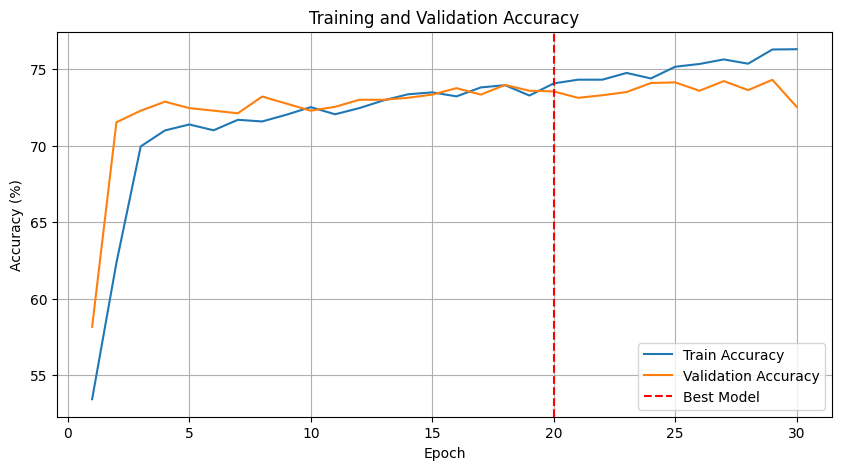

Test Accuracy: 72.67


In [29]:
# Step 1: Setup data
train_loader, val_loader, test_loader, num_classes, le, shape = setup_data_from_precomputed_type(batch_size = 256)

# Step 2: Train model
model_path = train_model_type(train_loader, val_loader, num_classes, shape,
                         epochs = 100, print_every = 2, patience = 10, 
                         plot_losses=False, plot_accuracies=True)

# Step 3: Test model
test_accuracy = test_model_type(test_loader, model_path, num_classes,shape)


## Looking at the predictions

In [30]:
le.inverse_transform([2]).tolist()

['run']

In [31]:
def get_all_predictions(model_path,train_loader,val_loader,test_loader,le):
    model = OffenseFormationCNN_type(num_classes,shape[0],shape[1])
    model.load_state_dict(torch.load(model_path,weights_only=True))
    model.eval()
    
    
    with torch.no_grad():
        game_ids = []
        play_ids = []
        all_predictions = []
        truths = []
        type = []
    
        for inputs, labels, other_x, ids in train_loader:
            inputs = inputs.unsqueeze(1)  # Add channel dimension
            outputs = model(inputs,other_x)
            predictions = outputs.argmax(dim=1)
            
            game_ids.extend(ids[0].tolist())
            play_ids.extend(ids[1].tolist())
            all_predictions.extend(le.inverse_transform([pred.item() for pred in predictions]).tolist())
            truths.extend(le.inverse_transform(labels.tolist()).tolist())
            type.extend(['train'] * len(predictions))
    
        for inputs, labels, other_x, ids in val_loader:
            inputs = inputs.unsqueeze(1)  # Add channel dimension
            outputs = model(inputs,other_x)
            predictions = outputs.argmax(dim=1)
            
            game_ids.extend(ids[0].tolist())
            play_ids.extend(ids[1].tolist())
            all_predictions.extend(le.inverse_transform([pred.item() for pred in predictions]).tolist())
            truths.extend(le.inverse_transform(labels.tolist()).tolist())
            type.extend(['val'] * len(predictions))
        
        for inputs, labels, other_x, ids in test_loader:
            inputs = inputs.unsqueeze(1)  # Add channel dimension
            outputs = model(inputs,other_x)
            predictions = outputs.argmax(dim=1)
            
            game_ids.extend(ids[0].tolist())
            play_ids.extend(ids[1].tolist())
            all_predictions.extend(le.inverse_transform([pred.item() for pred in predictions]).tolist())
            truths.extend(le.inverse_transform(labels.tolist()).tolist())
            type.extend(['test'] * len(predictions))
            
    
    results = pd.DataFrame({'gameId':game_ids,
                            'playId':play_ids,
                            'prediction':all_predictions,
                            'truth':truths,
                            'split':type})
    return results

In [32]:
predictions = get_all_predictions(model_path,train_loader,val_loader,test_loader,le)
predictions['correct'] = (predictions['prediction'] == predictions['truth']).astype(int)
predictions = predictions.merge(plays,on=['gameId','playId'],how='left')
predictions

,gameId,playId,prediction,truth,split,correct,playDescription,quarter,down,yardsToGo,...,visitorTeamWinProbilityAdded,expectedPointsAdded,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone,rushAttempt,type
0,2022091100,121,run,pass,train,0,(13:41) (Shotgun) M.Mariota pass short middle ...,1,3,4,...,-0.031911,1.691266,True,TRICK,NaN,0,Cover-2,Zone,0,pass
1,2022091811,1796,pass,pass,train,1,(:30) (Shotgun) D.Carr scrambles right end to ...,2,2,15,...,0.000947,-0.069484,True,NaN,NaN,0,Cover 6-Left,Zone,1,pass
2,2022102305,2858,run,run,train,1,(11:49) D.Henry up the middle to IND 44 for 6 ...,4,2,5,...,-0.008437,0.521267,False,MAN,NaN,0,Cover-3,Zone,1,run
3,2022091812,2299,run,pass,train,0,(5:06) A.Rodgers pass short left to R.Tonyan p...,3,1,10,...,0.000100,-0.356362,True,OUTSIDE ZONE,NaN,0,Cover-3,Zone,0,pass
4,2022101609,1713,pass,pass,train,1,(1:12) (Shotgun) K.Murray sacked at ARZ 27 for...,2,2,10,...,-0.070024,-1.109111,True,NaN,NaN,0,Cover-1,Man,0,pass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15869,2022102700,3527,pass,run,test,0,"(6:08) (No Huddle, Shotgun) R.White up the mid...",4,3,2,...,-0.010962,1.118388,False,MAN,NaN,0,Cover 6-Left,Zone,1,run
15870,2022102305,603,pass,run,test,0,(4:03) (Shotgun) J.Taylor left tackle to IND 3...,1,1,10,...,-0.005914,-0.050386,False,MAN,NaN,0,Cover-3,Zone,1,run
15871,2022102000,3319,rpo,run,test,0,(9:45) (Shotgun) E.Benjamin up the middle to N...,4,1,10,...,-0.018828,1.748906,False,MAN,NaN,0,Cover-1,Man,1,run
15872,2022091103,632,run,run,test,1,(5:08) J.Mixon left tackle to CIN 40 for 5 yar...,1,2,10,...,0.005160,-0.249397,False,OUTSIDE ZONE,NaN,0,Cover-3,Zone,1,run


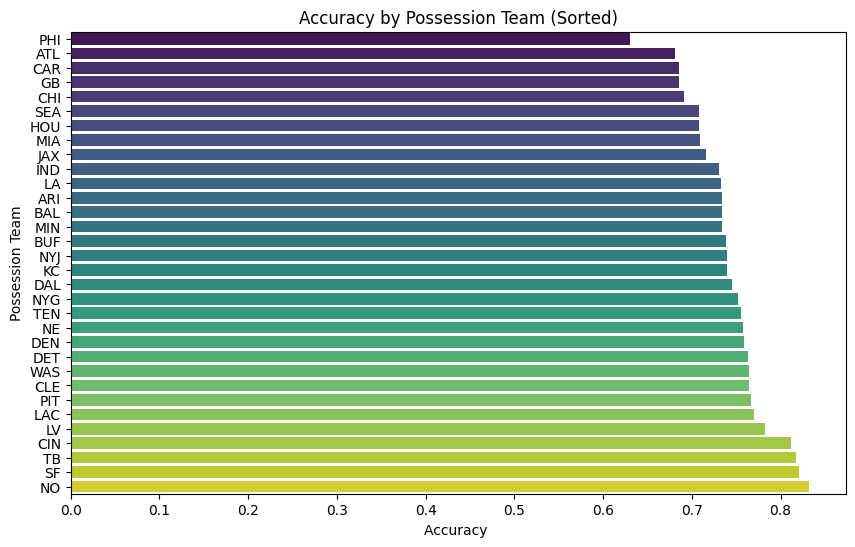

In [33]:
# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=predictions.groupby('possessionTeam')['correct'].mean().sort_values().reset_index(), y='possessionTeam', x='correct', palette='viridis')
plt.title("Accuracy by Possession Team (Sorted)")
plt.xlabel("Accuracy ")
plt.ylabel("Possession Team")
plt.show()

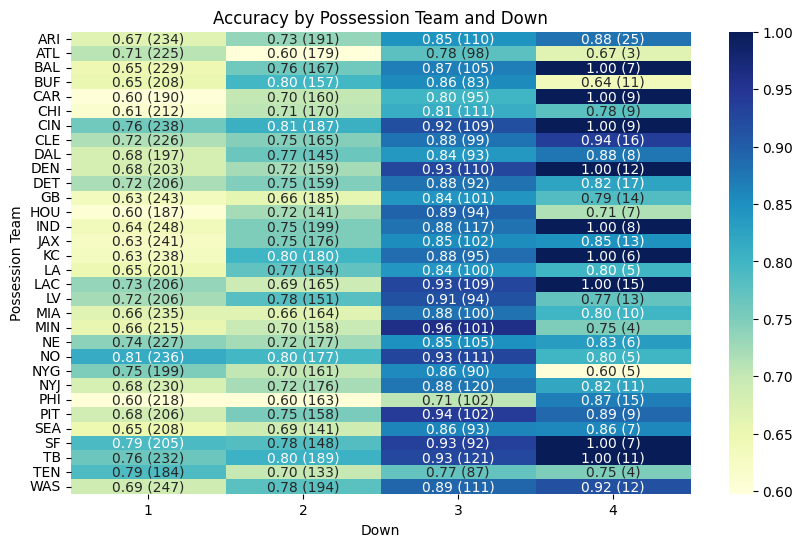

In [34]:
# Compute mean and count values
grouped = predictions.groupby(['possessionTeam', 'down'])['correct']
means = grouped.mean().unstack()
counts = grouped.count().unstack()

# Create a DataFrame for custom annotations with dtype=object
annot = means.astype(str).copy()
for i in range(means.shape[0]):
    for j in range(means.shape[1]):
        if not np.isnan(means.iloc[i, j]):  # Handle NaN values
            annot.iloc[i, j] = f"{means.iloc[i, j]:.2f} ({counts.iloc[i, j]})"
        else:
            annot.iloc[i, j] = ""  # Leave empty for NaN values

# Plot the heatmap with custom annotations
plt.figure(figsize=(10, 6))
sns.heatmap(means, annot=annot, fmt="", cmap="YlGnBu", cbar=True)
plt.title("Accuracy by Possession Team and Down")
plt.xlabel("Down")
plt.ylabel("Possession Team")
plt.show()

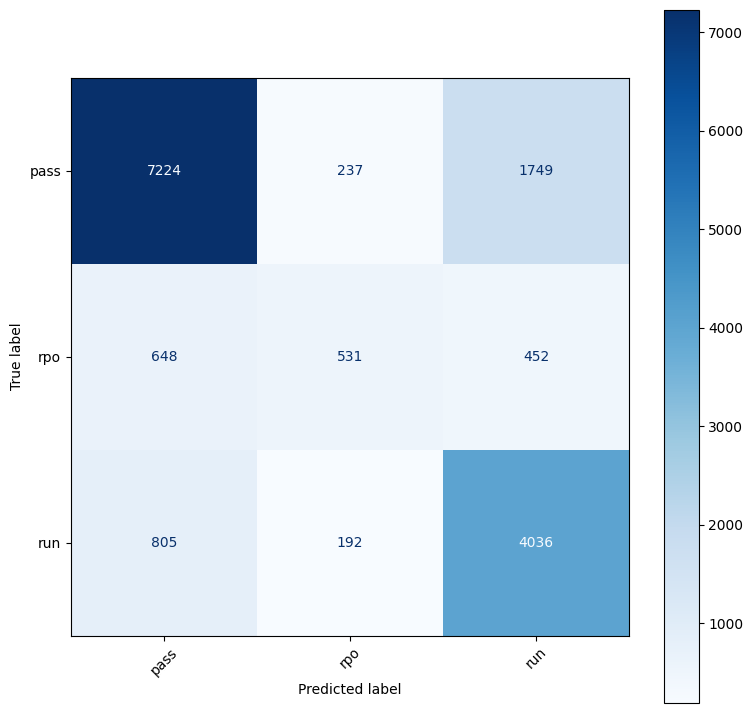

In [35]:
# Define the correct order of labels
label_order = sorted(set(predictions['truth']).union(set(predictions['prediction'])))

# Generate confusion matrix with specified label order
cm = confusion_matrix(predictions['truth'], predictions['prediction'], labels=label_order)

# Display the confusion matrix with consistent label order
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_order)
fig, ax = plt.subplots(figsize=(9,9))  # Adjust figure size as needed
cmd.plot(cmap="Blues", ax=ax, values_format='d')

# Rotate x-axis labels
plt.xticks(rotation=45)
plt.show()

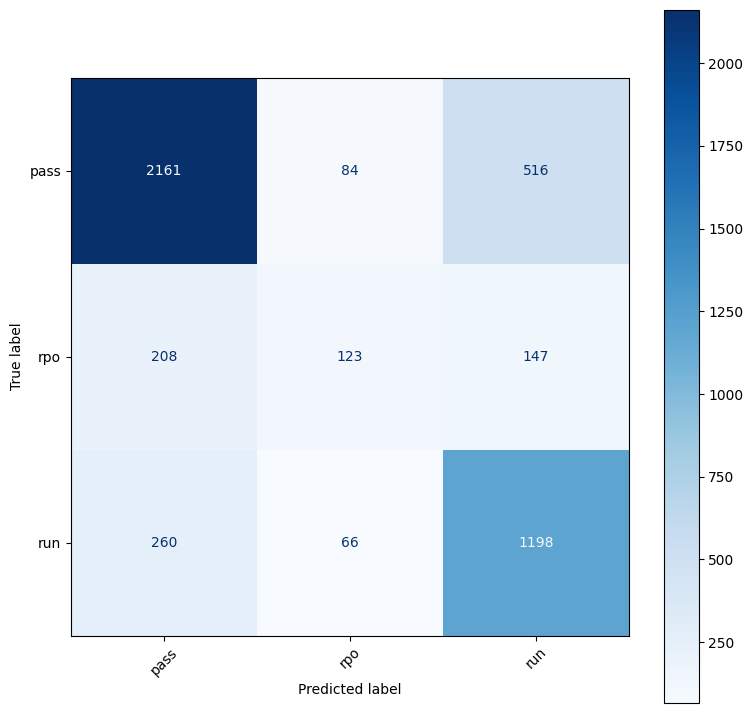

In [36]:
# Define the correct order of labels
not_train = predictions[predictions['split']!= 'train']
label_order = sorted(set(not_train['truth']).union(set(not_train['prediction'])))

# Generate confusion matrix with specified label order
cm = confusion_matrix(not_train['truth'], not_train['prediction'], labels=label_order)

# Display the confusion matrix with consistent label order
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_order)
fig, ax = plt.subplots(figsize=(9,9))  # Adjust figure size as needed
cmd.plot(cmap="Blues", ax=ax, values_format='d')

# Rotate x-axis labels
plt.xticks(rotation=45)
plt.show()